# Homework 5 - The eternal significance of publications and citations!

#### Group 15 <br>

<div style="float: left;">
    <table>
        <tr>
            <th>Student</th>
            <th>GitHub</th>
            <th>Matricola</th>
            <th>E-Mail</th>
        </tr>
        <tr>
            <td>André Leibrant</td>
            <td>JesterProphet</td>
            <td>2085698</td>
            <td>andre.leibrant@gmx.de</td>
        </tr>
        <tr>
            <td>Gianluca Procopio</td>
            <td>gianluca-24</td>
            <td>1942103</td>
            <td>procopio.1942103@studenti.uniroma1.it</td>
        </tr>
    </table>
</div>

#### Import Libraries and Modules

In [68]:
import ast
import csv
import json
import networkx as nx
import pandas as pd

## 1. Data
In this homework, you will work on a dataset that contains information about a group of papers and their citation relationships. You can find and download the dataset [here](https://www.kaggle.com/datasets/mathurinache/citation-network-dataset).

### Graphs setup
Based on the available data, you will create two graphs to model our relationships as follows:

1. **Citation graph:** This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2. **Collaboration graph:** This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing
The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.

As a result, you will attempt to approximate that most connected component by performing the following steps:

1. Identify the top **10,000 papers** with the <u>highest number of citations</u>.


2. Then the **nodes** of your graphs would be as follows:

    **Citation graph:** you can consider each of the papers as your nodes

    **Collaboration graph:** the authors of these papers would be your nodes


3. For the **edges** of the two graphs, you would have the following cases:

    **Citation graph:** only consider the citation relationship between these 10,000 papers and ignore the rest.

    **Collaboration graph:** only consider the collaborations between the authors of these 10,000 papers and ignore the rest.
    
---

We decided to read the large JSON file line by line and save the paper `id` with corresponding `n_citation` in a list.

---

In [ ]:
# File path for papers json file
file_path = "data.json"

# List to store paper information
papers = []

# Open the papers json file
with open(file_path, "r") as file:
    
    # Iterate through every line of the file
    for line_number, line in enumerate(file):
        
        # Remove the leading comma
        if line.startswith(","):
            line = line[1:]
        
        # Skip the opening and ending braket
        if len(line) > 2:
            
            # Skip lines that have non-readable characters
            try:
            
                # Parse the json line
                data = json.loads(line)

                # Extract the id and number of citations (set to 0 if doesn't exist)
                paper_id = data["id"]
                paper_citations = data.get("n_citation", 0)

                # Append the information to the list
                papers.append({"id": paper_id, "n_citations": paper_citations})
                
            except:
                pass

---

In the next step we sort the list by `n_citations`, extract the top 10,000 entries and convert the id key values to a list.

---

In [ ]:
# Sort the list based on the number of citations
papers.sort(key=lambda paper: paper["n_citations"], reverse=True)

# Extract the top 10000 entries
top_10000_papers = papers[:10000]

# Convert id key values to list
paper_ids = [paper["id"] for paper in top_10000_papers]

---

Finally, we are going to iterate through the JSON file again and only extract the papers which are inside the top 10,000 list.

---

In [7]:
# Initialize an empty Pandas DataFrame
df_top_10000_papers = pd.DataFrame()

# Open the papers json file
with open(file_path, "r") as file:
    
    # Iterate through every line of the file
    for _, line in enumerate(file):
        
        # Remove the leading comma
        if line.startswith(","):
            line = line[1:]
        
        # Skip the opening and ending braket
        if len(line) > 2:
            
            # Skip lines that have non-readable characters
            try:
            
                # Parse the json line
                data = json.loads(line)

                # Only append if the id is from the top 10000 papers list
                if data["id"] in paper_ids:

                    # Load the json string into a temporary Pandas DataFrame
                    tmp_df = pd.read_json(line, lines=True)

                    # Append the temporary DataFrame to the main DataFrame
                    df_top_10000_papers = pd.concat([df_top_10000_papers, tmp_df], ignore_index=True)
            
            except:
                pass

---

We save the final result inside a CSV file, so that we don't have to always rerun the previous steps.

---

In [9]:
# Save results in CSV file
df_top_10000_papers.to_csv("top_10000_papers.csv", index=False)

---

We read the results inside the CSV file into a Pandas DataFrame for creating the citation and collaboration graphs.

---

In [ ]:
# Read results from CSV file
df_top_10000_papers = pd.read_csv("top_10000_papers.csv")

---

First, we are going to create the citation (direct) graph using the paper's citation relationships. For this we extract all unique values between paper `ids` and `references` (which we convert from a string to a list of integers) and save the results inside `all_nodes`. Then we iterate through every paper, add the node if it is inside `all_nodes`, and add the edge between the `id` and `reference` if both are inside `all_nodes`.

---

In [104]:
# Drop all entries where the references field is empty
df_top_10000_papers = df_top_10000_papers.dropna(subset=["references"])

# Create an empty directed graph for the citations
citation_graph = nx.DiGraph()

# Get all unique paper ids
unique_ids = df_top_10000_papers["id"].unique()

# Extract all references and convert to a list of integers
reference_values = []
for references_str in df_top_10000_papers["references"]:
    references_list = ast.literal_eval(references_str)
    reference_values.extend(references_list)

# Get all unique values between both columns
all_nodes = set(unique_ids).union(set(reference_values))

# Add nodes and edges to the graph only for the nodes present in the file
for _, row in df_top_10000_papers.iterrows():
    paper_id = row["id"]
    references = ast.literal_eval(row["references"])
    
    # Add node if not already added
    if paper_id not in citation_graph.nodes:
        citation_graph.add_node(paper_id)
    
    # Add edges for references that are in the file
    for ref_id in references:
        if ref_id in all_nodes:
            citation_graph.add_edge(paper_id, ref_id)

---

Next, we are going to create the collaboration (undirected and weigthed) graph using the collaborations of the paper's authors. For this we iterate through every paper and convert the authors list from a string to a list of dictionaries. Then we iterate through every pair of authors and add the nodes and edges if they don't exist yet. For the edge weight we decided to use the number of times two authors have collaborated. We are going to count the number of collaborations between each pair of authors and use that count as the weight.

---

In [248]:
# Create an empty undirected graph for the collaboration
collaboration_graph = nx.Graph()

# Iterate through each row in the DataFrame
for _, paper in df_top_10000_papers.iterrows():
    
    # Convert the string to a list of dictionaries
    authors_list = ast.literal_eval(paper["authors"])

    # Iterate through every pair of authors
    for i, author_i_dict in enumerate(authors_list):
        for j, author_j_dict in enumerate(authors_list[i+1:], start=i+1):
            
            # Retrieve author names
            author_i = author_i_dict["name"]
            author_j = author_j_dict["name"]
            
            # Initialize weight to 1
            weight = 1
            
            # Add nodes
            collaboration_graph.add_nodes_from([author_i, author_j])
            
            # Add edge if not already added and if yes, increase the weight by 1
            if not collaboration_graph.has_edge(author_i, author_j):
                collaboration_graph.add_edge(author_i, author_j, weight=weight)
                collaboration_graph[author_i][author_j]["titles"] = [paper["title"]]
            else:
                collaboration_graph[author_i][author_j]["weight"] += 1
                collaboration_graph[author_i][author_j]["titles"] += [paper["title"]]

## 4. Command Line Question (CLQ)
In this question, you should use any command line tools that you know to answer the following questions using the **directed** and **unweighted graph** that you have previously created: **Citation graph**:

---

Before solving the questions in the Command Line we find the largest strongly connected component and save the subgraph inside a file which we are going to use in the Command Line. We decided to work on a subgraph for computation time reasons.

In [256]:
# Get all strongly connected components
strongly_connected_components = nx.strongly_connected_components(citation_graph)

# Find the largest strongly connected component
largest_component = max(strongly_connected_components, key=len)

# Create a subgraph from the largest component
citation_subgraph = citation_graph.subgraph(largest_component)

---

We quickly plot the subgraph:

---

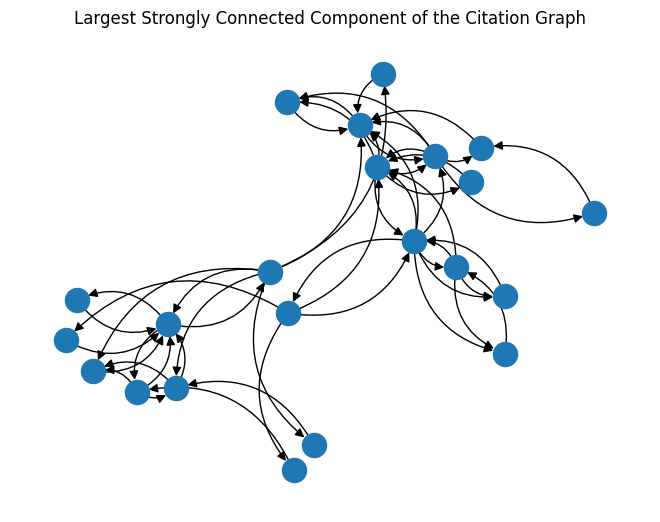

In [257]:
# Plot the subgraph
pos = nx.spring_layout(citation_subgraph)
nx.draw(citation_subgraph,
        pos,
        with_labels=False,
        arrowsize=13,
        connectionstyle="arc3, rad=0.4")
plt.title("Largest Strongly Connected Component of the Citation Graph")
plt.show()

---

At last we save the subgraph in a file.

---

In [254]:
nx.write_edgelist(citation_subgraph, "citation_subgraph.edgelist", data=False)

---

1. Is there any node that acts as an important "connector" between the different parts of the graph?

To identify a possible important connector we are going to calculate the betweenness centrality for each note:

```bash
# Calculate betweenness centrality for each node
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); print('\n'.join([f'{node} {centrality}' for node, centrality in nx.betweenness_centrality(citation_subgraph).items()]))" > betweenness_centrality.txt

# Sort nodes by betweenness centrality in descending order
sort -k2 -rn betweenness_centrality.txt > sorted_betweenness_centrality.txt

# Print the top connectors
head -n 10 sorted_betweenness_centrality.txt
```

![Screenshot1](Screenshot1.png)

**Conclusion:** The node with the paper id `2121127625` has a betweenness centrality score of 0.51 which indicates that, on average, half of the shortest paths in the graph pass through that specific node. The nodes with the paper ids `2032210760`, `2107890099`, and `1975846642` have a similar importance.

2. How does the degree of citation vary among the graph nodes?

```bash
# Calculate in-degrees for each node
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); print('\n'.join([f'{node} {in_degree}' for node, in_degree in citation_subgraph.in_degree()]))" > in_degrees.txt

# Calculate out-degrees for each node
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); print('\n'.join([f'{node} {out_degree}' for node, out_degree in citation_subgraph.out_degree()]))" > out_degrees.txt
```

3. What is the average length of the shortest path among nodes?